In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('default')
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import datetime
from matplotlib.animation import PillowWriter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Data Import

In [2]:
project_hours = pd.read_csv('project_hours_normalized.csv')
time_tracking = pd.read_csv('time_tracking.csv')

In [3]:
# change date columns to datetime
project_hours[['fund_date', 'start_date', 'finish_date']] = project_hours[['fund_date', 'start_date', 'finish_date']].astype('datetime64[s]')
time_tracking['datetime'] = time_tracking['datetime'].astype('datetime64[s]')

# Add days of week, week #, and year columns to time_tracking
time_tracking['day_of_week'] = time_tracking['datetime'].dt.day_name() 
time_tracking['year'] = time_tracking['datetime'].dt.year
time_tracking['week'] = time_tracking['datetime'].dt.isocalendar().week

In [4]:
#project_hours.info()
#time_tracking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype        
---  ------                     --------------  -----        
 0   artist                     227 non-null    object       
 1   song_name                  232 non-null    object       
 2   fund_date                  113 non-null    datetime64[s]
 3   start_date                 133 non-null    datetime64[s]
 4   finish_date                200 non-null    datetime64[s]
 5   price                      113 non-null    float64      
 6   total_additional_payments  21 non-null     float64      
 7   expenses                   16 non-null     float64      
 8   project_type               234 non-null    object       
 9   soundbetter                234 non-null    bool         
 10  spec_project               234 non-null    bool         
 11  songwriter                 234 non-null    bool         
 12  experienced_client    

# Exploratory Analysis

## Pricing Visualizations


In [5]:
# Filter 'project_hours' by projects that are marked 'Done'

project_hours_tracked_paid = project_hours[(project_hours['status'].str.lower() == 'done') 
                                      & (project_hours['time_tracked'] == True)
                                      & (project_hours['spec_project'] == False)] 
project_hours_done_full_production_paid = project_hours[(project_hours['project_type'].str.lower() == 'full production') 
                                                       & (project_hours['status'].str.lower() == 'done')
                                                       & (project_hours['spec_project'] == False)
                                                       & (project_hours['time_tracked'] == True)]

project_hours_tracked_paid.head()

,artist,song_name,fund_date,start_date,finish_date,price,total_additional_payments,expenses,project_type,soundbetter,...,fully_produced,time_tracked,status,total_hours,total_after_fees,master_ownership,song_ownership,project_hourly,days_to_finish,days_to_start
19,Cody Qualls,Good Vibes,2019-09-03,2020-10-30,2021-02-16,0.466667,NaN,0.00704,full production,False,...,True,True,Done,24.38,0.459627,NaN,NaN,0.018853,109.0,423.0
20,Jeff,DaysGone,2019-10-10,2020-02-13,2020-04-09,0.240000,NaN,NaN,track production,True,...,True,True,Done,12.92,0.221064,NaN,NaN,0.017109,56.0,126.0
21,Ananya Kouds,Marble Eyes,2019-12-09,2020-02-03,2020-04-06,0.226667,NaN,NaN,full production,True,...,True,True,Done,23.36,0.208784,NaN,NaN,0.008939,63.0,56.0
22,Cody G,Moving On,2020-02-13,2020-02-14,2020-05-07,0.253333,NaN,NaN,track production,True,...,True,True,Done,12.21,0.233347,NaN,NaN,0.019112,83.0,1.0
23,Cameron Liddell,Fire and Floods,2020-03-30,2020-03-31,2020-06-07,0.200000,NaN,NaN,track production,True,...,True,True,Done,11.37,0.184221,NaN,NaN,0.016203,68.0,1.0


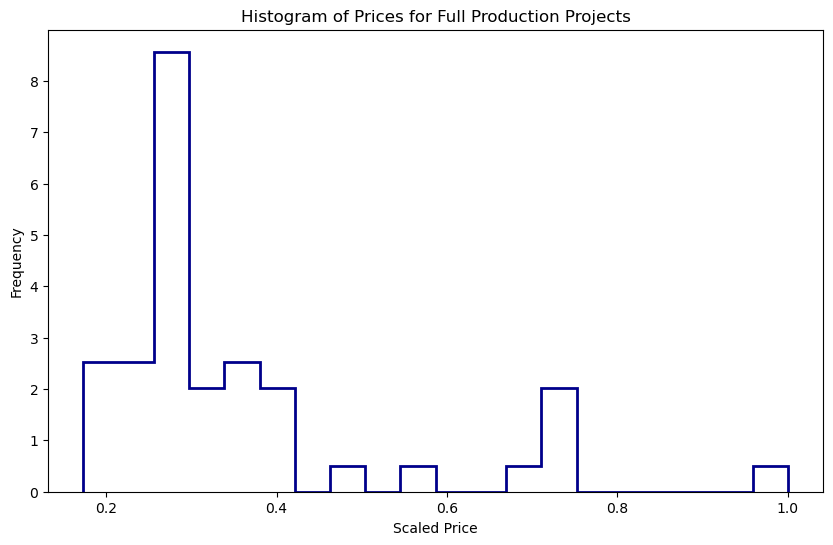

In [6]:
#Histogram of prices on finished full production projects

plt.figure(figsize=(10,6))
plt.hist(project_hours_done_full_production_paid['price'], density=True, histtype= 'step', linewidth = 2, bins=20, color='darkblue')

ax = plt.subplot()

plt.title('Histogram of Prices for Full Production Projects')
plt.xlabel('Scaled Price')
plt.ylabel('Frequency')

plt.show()

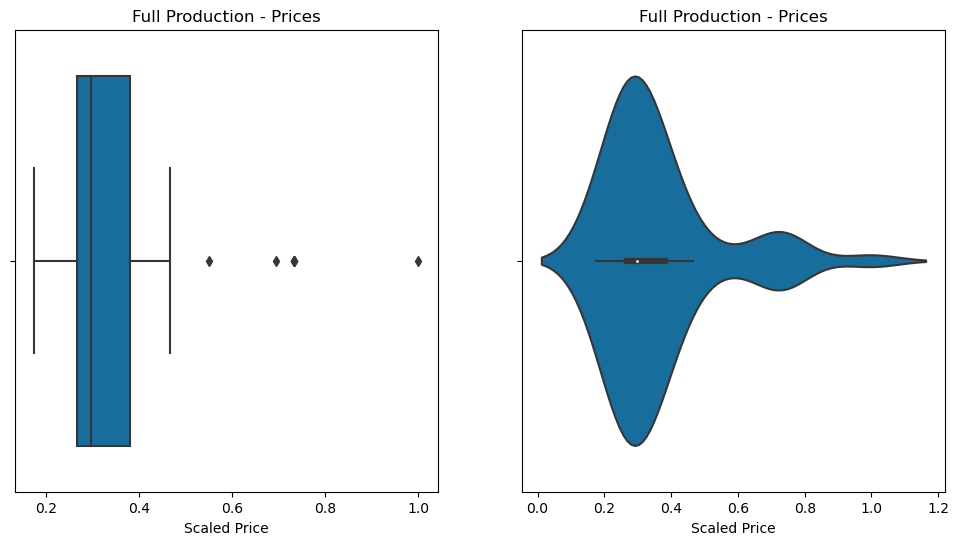

In [7]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')

plt.subplot(1,2,2)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.violinplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')
plt.show()

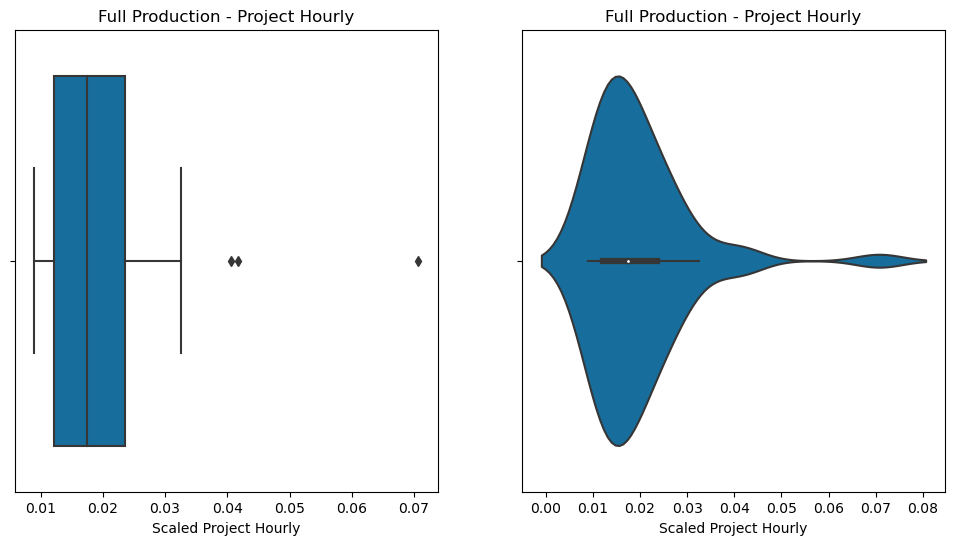

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')

plt.subplot(1,2,2)
sns.violinplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')
plt.show()

In [9]:
# Create a list of different project types
project_types = project_hours_tracked_paid['project_type'].unique().tolist()
print(project_types)
print(len(project_types))

['full production', 'track production', 'mixing', 'additional production', 'mastering', 'vocal production', 'production tweak', 'pre production']
8


In [10]:
def scatter_with_subplots(dataframe, x_values, y_values, categories, sns_palette, figsize_x, figsize_y):
    # Function that creates scatterplots with auto-arranged layout    
    import math

    # get the number or rows and columns for subplot
    categories_list = dataframe[categories].value_counts().index.tolist()
    number_of_subplots = len(categories_list)

    # set the number of rows for the subplot
    if number_of_subplots <= 4:
        rows = 1
    elif number_of_subplots <= 8:
        rows = 2
    elif number_of_subplots <= 12:
        rows = 3
    else:
        print('Too many categories.')
    
    columns = math.ceil(number_of_subplots/rows)
    subplot_index = 1
    palette_index = 0

    # create color palette
    palette_list = sns.color_palette(sns_palette, len(categories_list))

    # create subplots by iterating through 'categories_list' 
    plt.subplots(rows, columns, figsize=(figsize_x, figsize_y), sharey=True)
    for category in categories_list:
        plot_data = dataframe[dataframe[categories] == category]
        plt.subplot(rows, columns, subplot_index)
        ax = sns.scatterplot(x = x_values, y = y_values, data = plot_data, color= palette_list[palette_index], alpha = 0.5)
        plt.title(category)

        if len(plot_data) > 2:
            # Calculate the pearsonr value
            corr_coeff, _ = pearsonr(plot_data[x_values], plot_data[y_values])

            # Annotate the plot with pearsonr value
            ax.annotate(f"Pearson r: {corr_coeff:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

        subplot_index += 1
        palette_index += 1

    plt.tight_layout()
    plt.show()

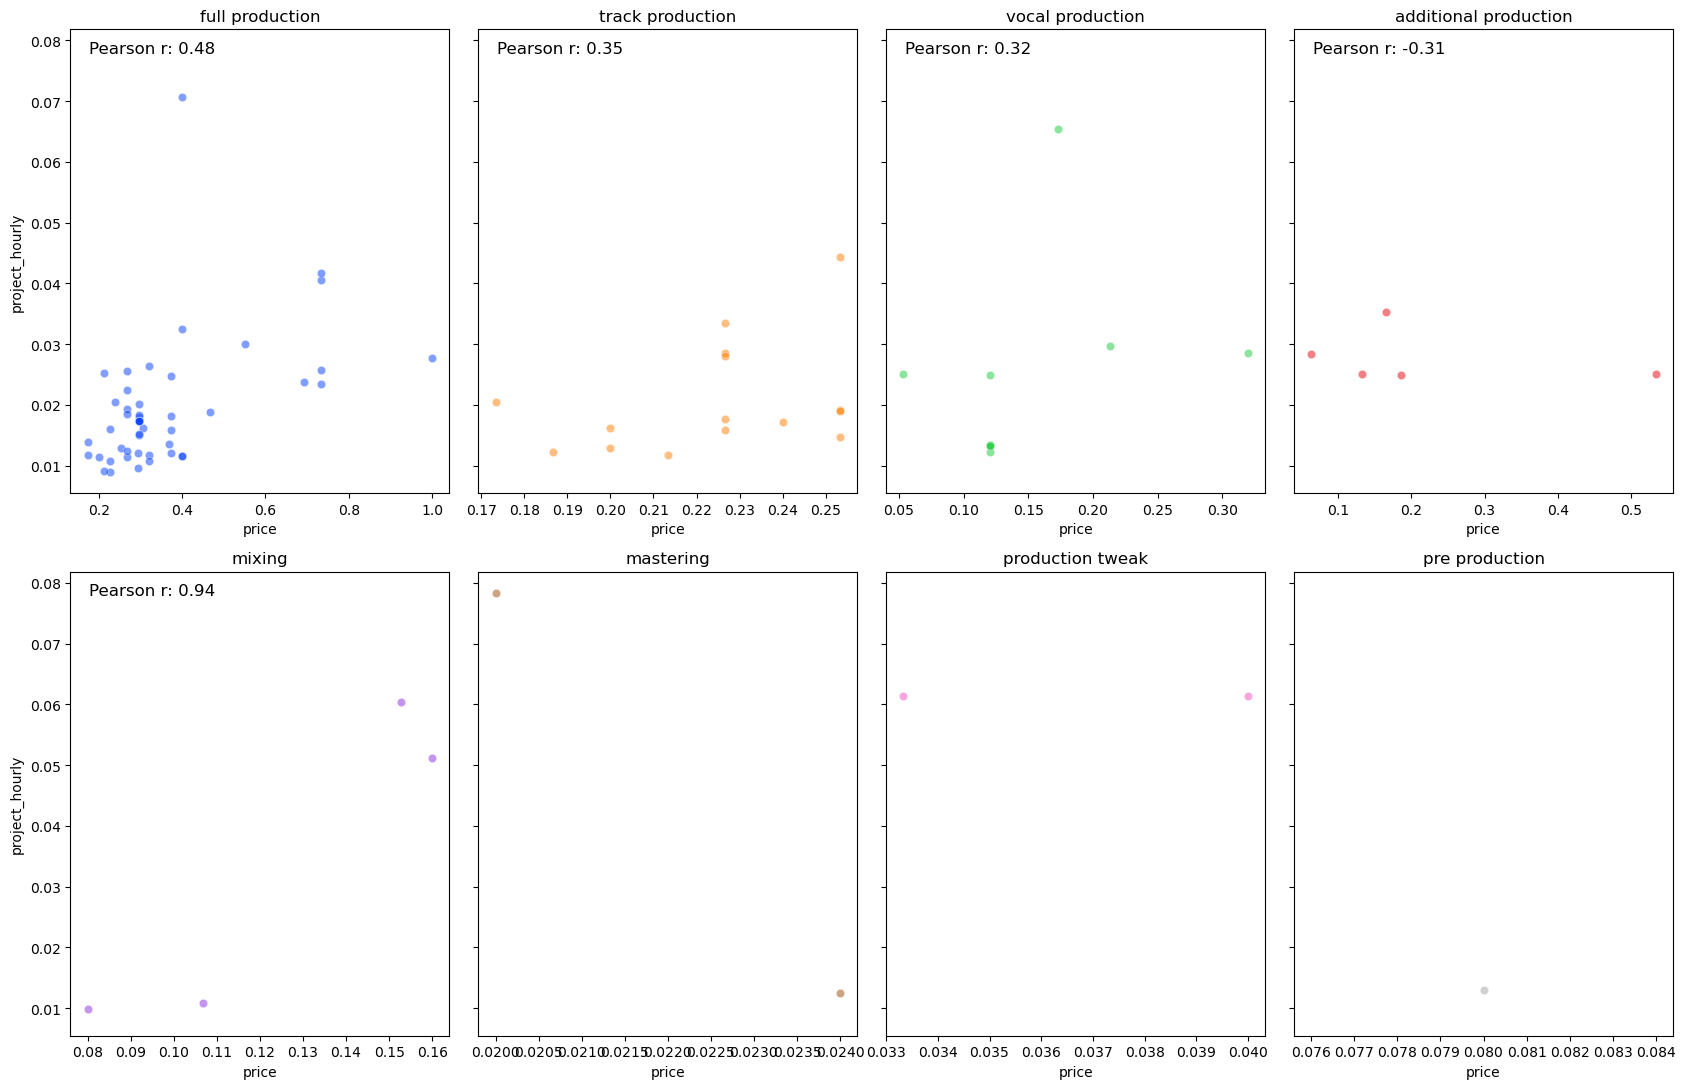

In [11]:
scatter_with_subplots(project_hours_tracked_paid, 'price', 'project_hourly', 'project_type', 'bright', 17, 11)

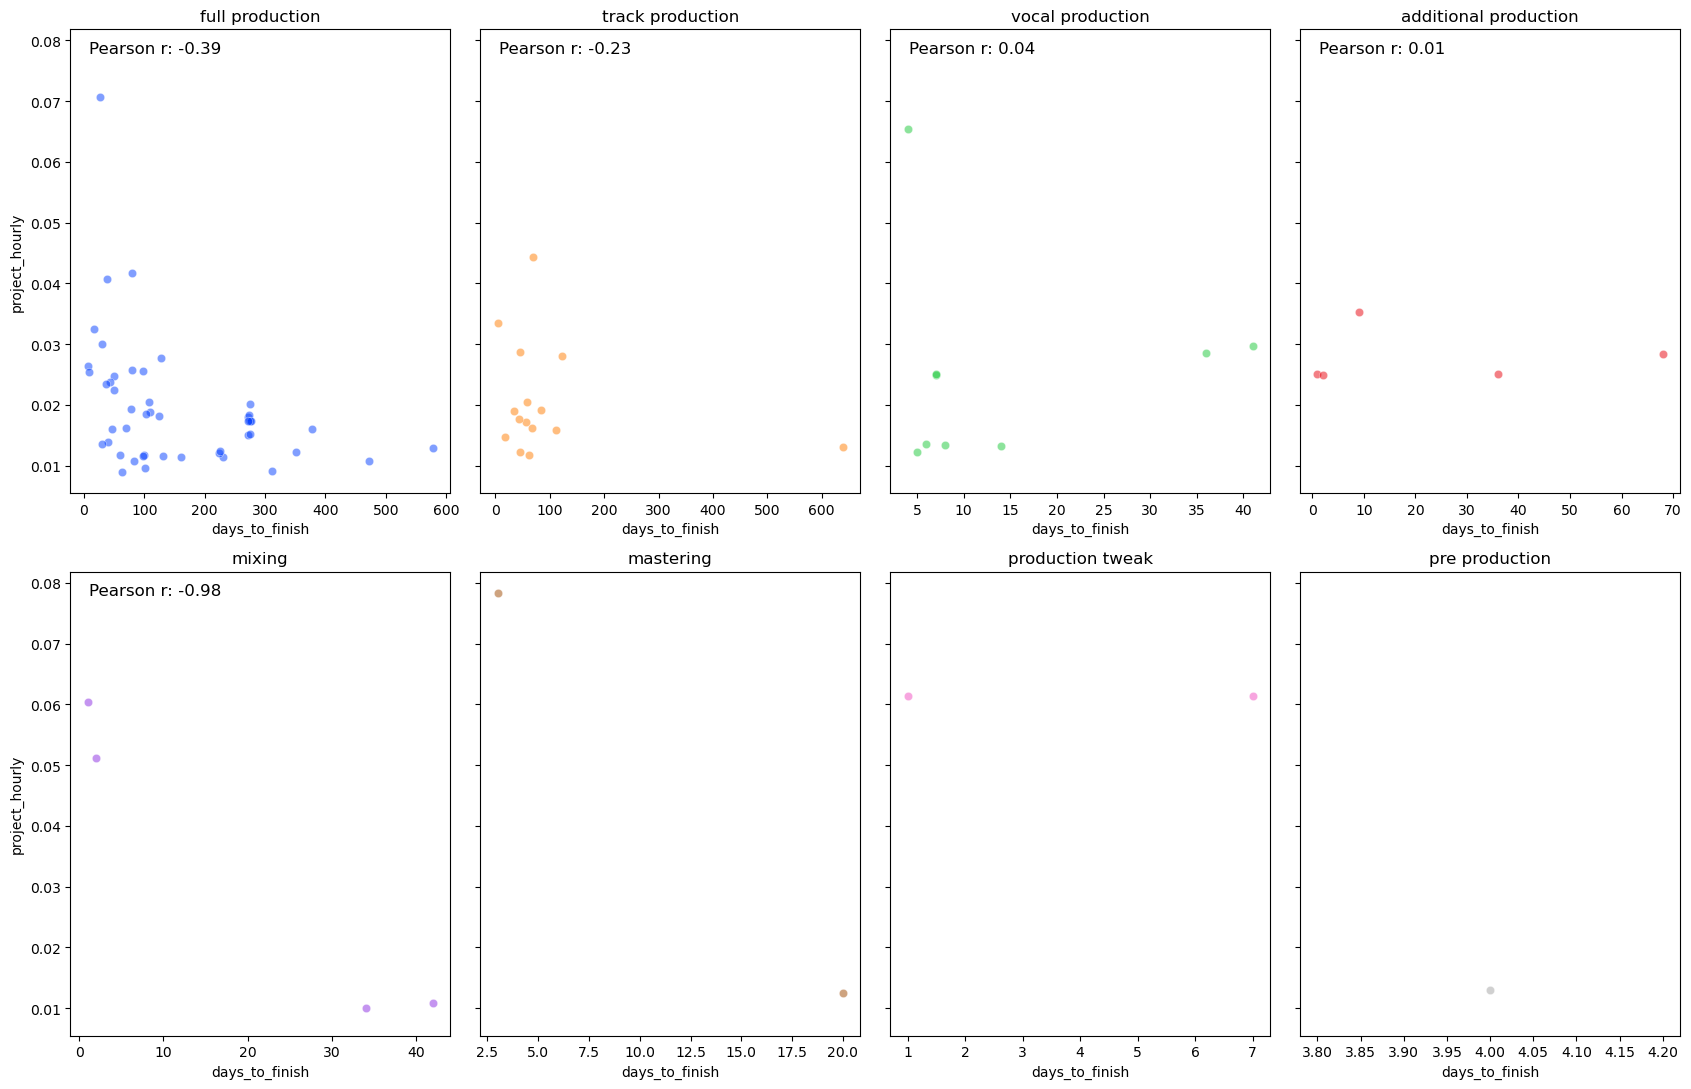

In [12]:
# Is there a correlation between days to finish a project and project hourly?
scatter_with_subplots(project_hours_tracked_paid, 'days_to_finish', 'project_hourly', 'project_type', 'bright', 17, 11)

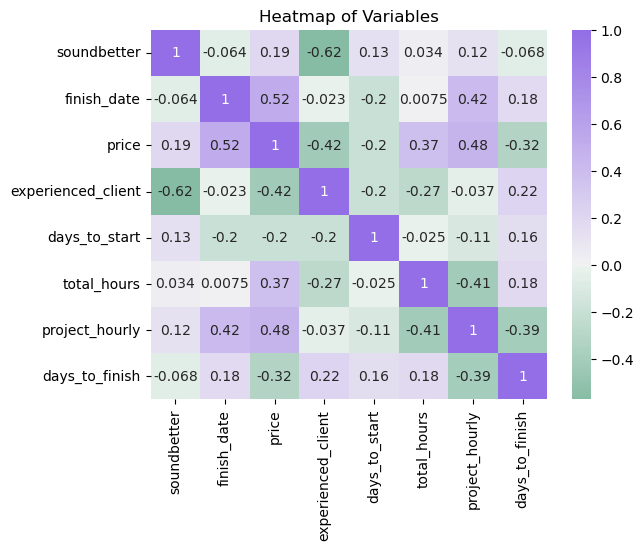

In [13]:
# Heatmap of project_hours_done
colors = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
# Create heatmap using the .corr method on df, set colormap to cmap
sns.heatmap(project_hours_done_full_production_paid[['soundbetter', 'finish_date', 'price', 'experienced_client', 'days_to_start',
                                'total_hours', 'project_hourly', 'days_to_finish']].corr(), center=0, cmap=colors, robust=True, annot=True)
plt.title("Heatmap of Variables")

plt.show()

c:\Users\matth\anaconda3\envs\tryba-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


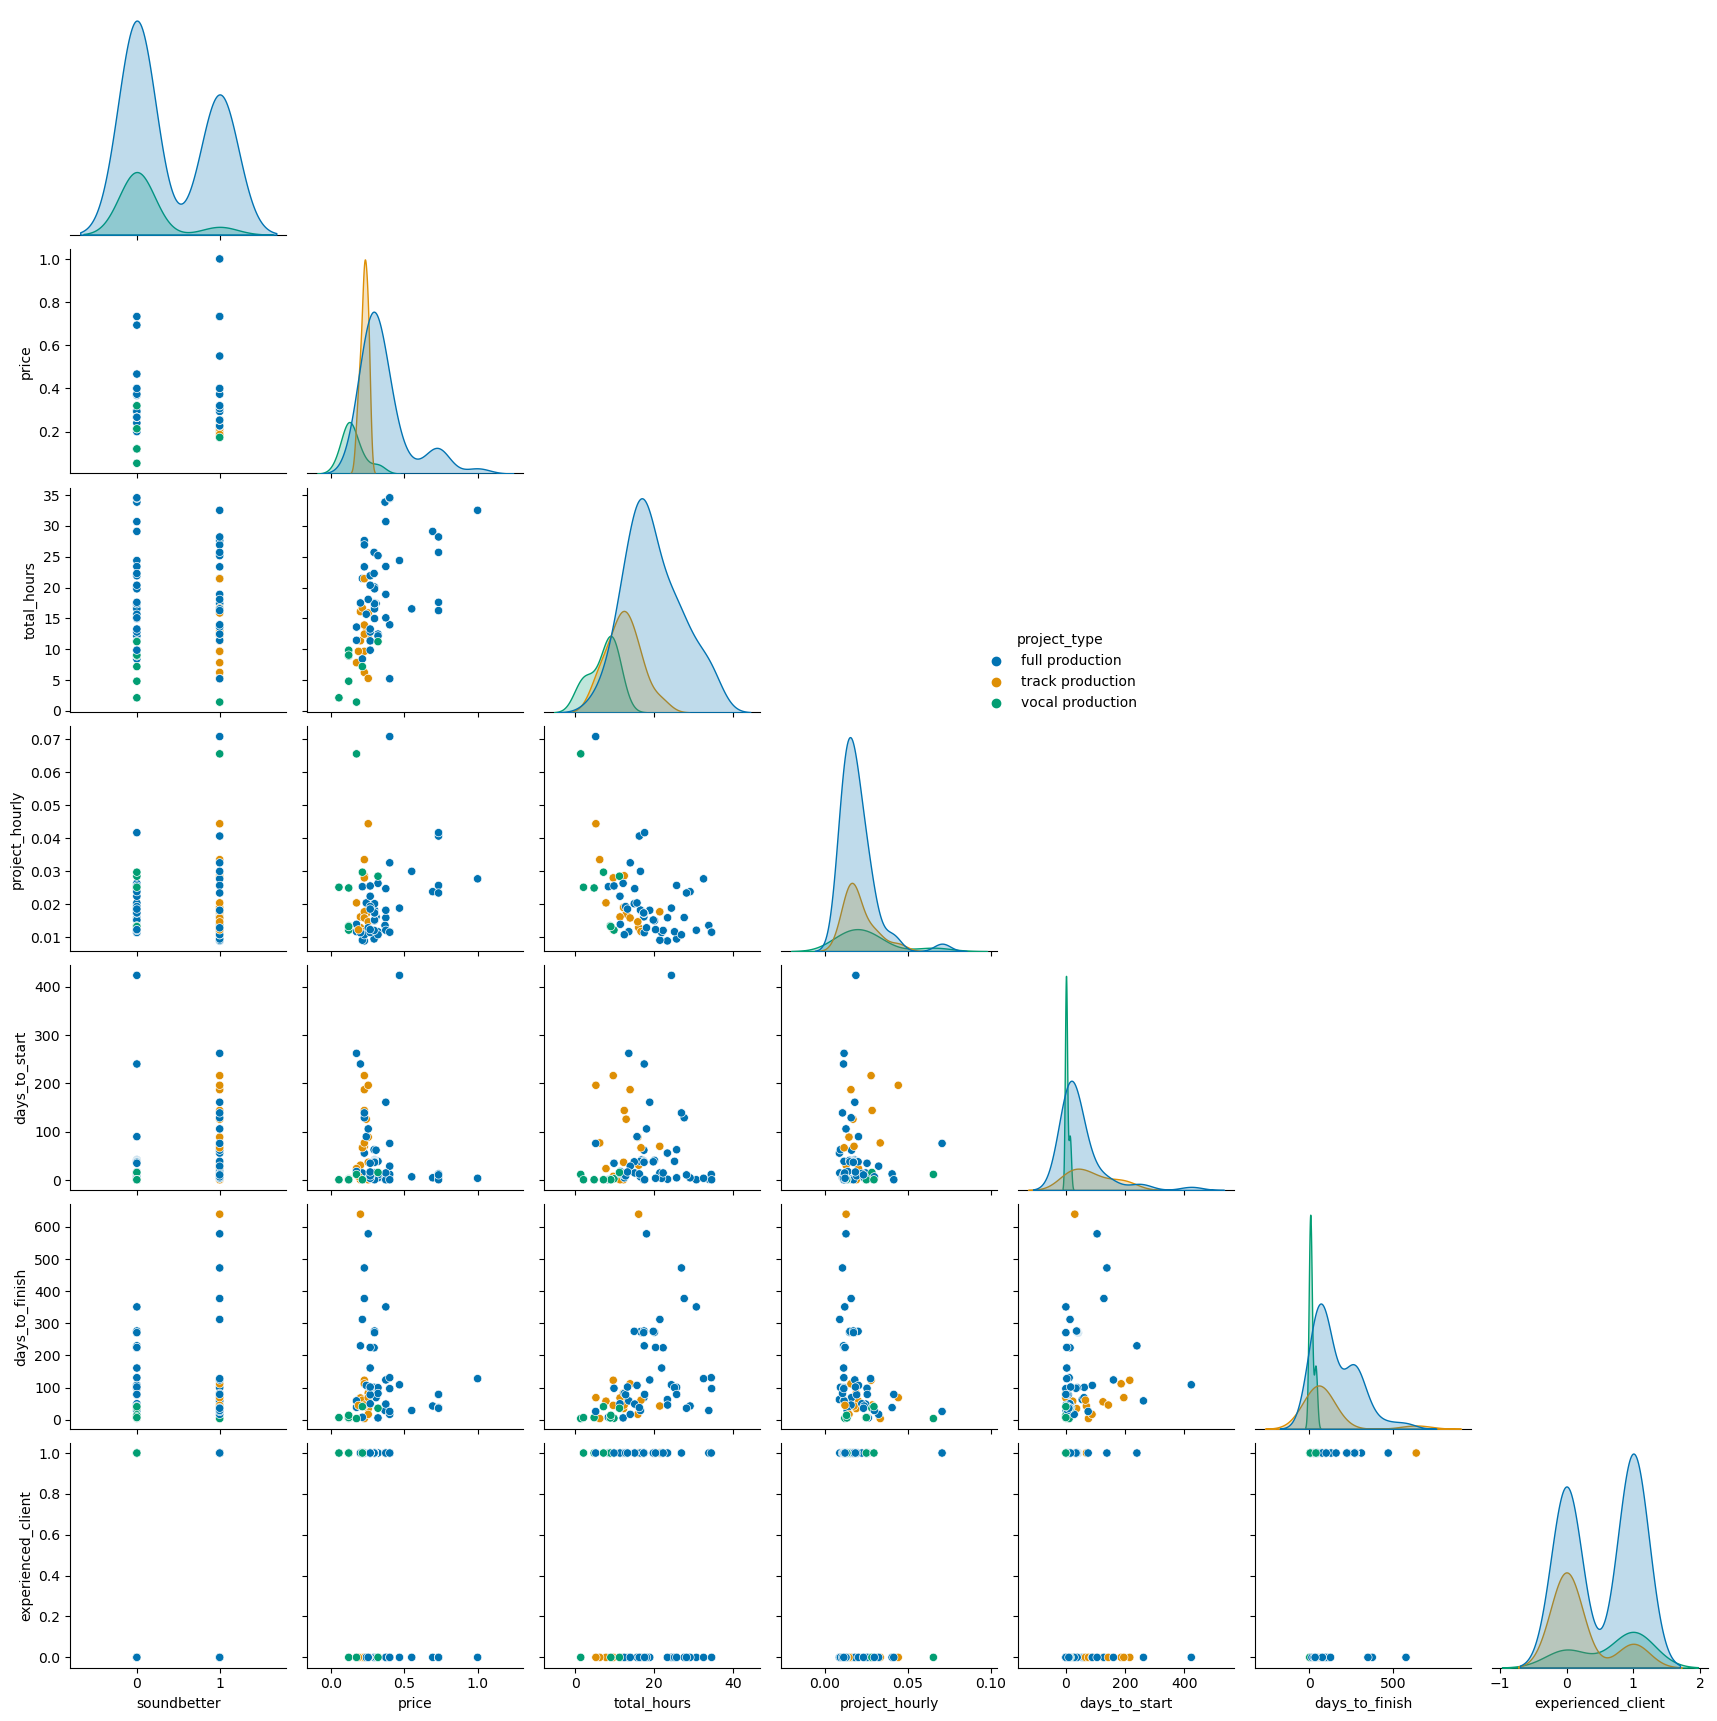

In [14]:
# pairplot different project types to screen for possible correlations
activity_list = ['full production', 'vocal production', 'track production']
project_hours_done_filtered_project_type = project_hours_tracked_paid[project_hours_tracked_paid['project_type'].isin(activity_list)]

plot_data = project_hours_done_filtered_project_type[['artist', 'soundbetter', 'fund_date', 'finish_date', 'price', 
                                                      'project_type', 'total_hours', 'project_hourly', 'days_to_start', 'days_to_finish', 'experienced_client']]

#Create Pairplots
pair_plot = sns.pairplot(plot_data, hue='project_type', palette='colorblind', corner=True)
pair_plot._legend.set_bbox_to_anchor((0.6, 0.6))  # Adjust the position of the legend

plt.savefig('pair_plot_project_hours.png')
plt.show()

## Time Management Analysis

### Length of Productivity Sessions

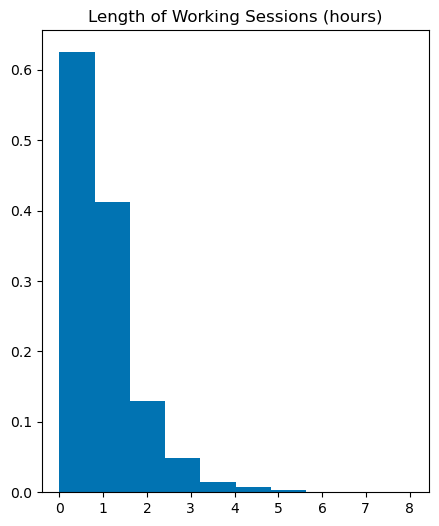

In [15]:
column_data = time_tracking['hours']
plt.figure(figsize=(5,6))
plt.hist(column_data, density=True)
plt.title('Length of Working Sessions (hours)')

plt.show()

### Total Hours Separated by Activity

In [16]:
# Filter business activites from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin', 'Sound Design', 'Engineering', 
                       'Practicing', 'Edu Data Science']
time_tracking_business = time_tracking[time_tracking['activity'].isin(business_activities)]

# sum total business hours by activity type
activity_total_hours = time_tracking_business.groupby('activity').hours.sum().reset_index(name='total_hours')
activity_total_hours = activity_total_hours.sort_values(by='total_hours', ascending=False)
activity_total_hours.head(20)

,activity,total_hours
1,Client Production,4187.94
4,Meridian Quake,1555.38
7,Spec,1049.80
0,Admin,720.57
6,Sound Design,231.35
3,Engineering,224.02
2,Edu Data Science,157.15
5,Practicing,128.42


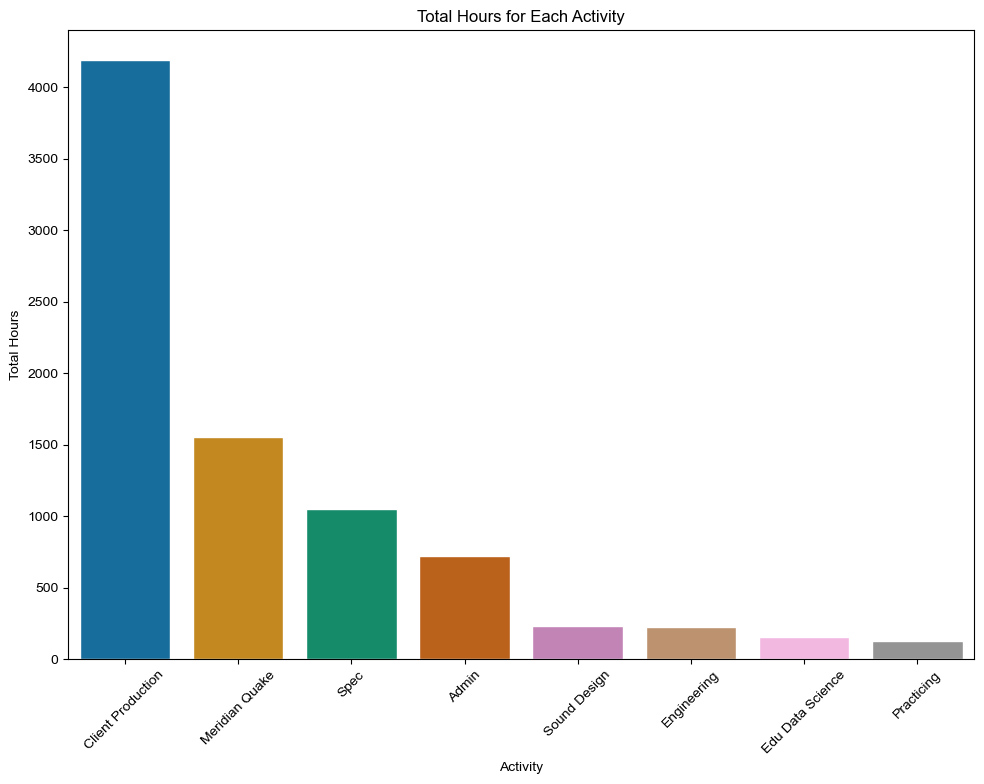

In [17]:
# create figure
plt.figure(figsize=(10,8))
ax = plt.subplot()

# Set the style of seaborn
sns.set(style="whitegrid")

# Choose a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=len(activity_total_hours))

# Create the bar plot with the chosen palette
sns.barplot(x='activity', y='total_hours', data=activity_total_hours, palette=palette)
plt.xticks(rotation=45)
plt.xlabel('Activity')
plt.ylabel('Total Hours')
plt.title('Total Hours for Each Activity')

plt.tight_layout()  # Ensures that labels and titles fit within the plot area
plt.show()

### Productivity By Day of Week

In [18]:
# Filter business activites from tracking input
business_activities = ['Client Production', 'Meridian Quake', 'Spec', 'Admin']

# Filter the years to be greater than 2016 and less than the current year
current_year = datetime.datetime.now().year
unique_years_temp = time_tracking[(time_tracking['activity'].isin(business_activities)) 
                                                & (time_tracking['year'] < current_year) 
                                                & (time_tracking['year'] > 2016)]

# Create list of years
years_list = unique_years_temp['year'].unique().tolist()
print(years_list)

[2017, 2018, 2019, 2020, 2021, 2022]


#### Creating gifs of actvities by week and by year

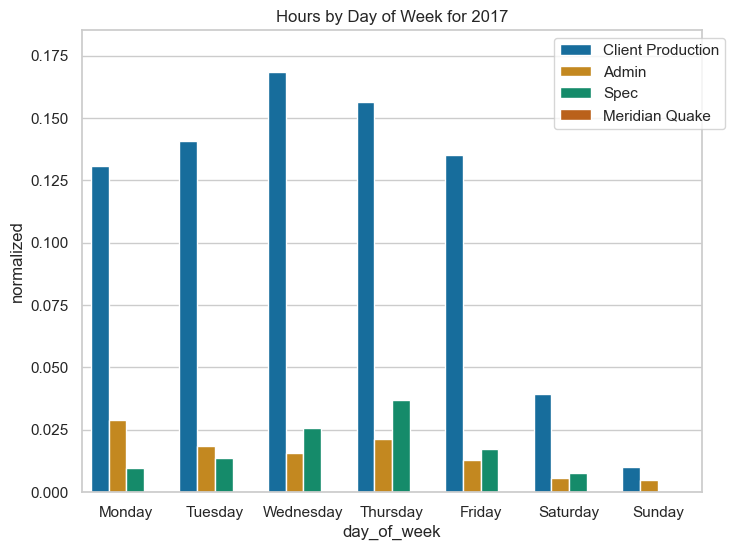

In [19]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, 'plots_normalized.gif', 100):
    max_hours_normalized = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='day_of_week', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()

        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='day_of_week', value_name='hours', var_name='activity')
        
        # Create normalized column
        plot_data['normalized'] = plot_data['hours']/plot_data['hours'].sum()
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours_normalized:
            max_hours_normalized = plot_data['normalized'].max() * 1.1

        # Sort by days_of_week
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plot_data['day_of_week'] = pd.Categorical(plot_data['day_of_week'], categories=days_order, ordered=True)
        plot_data = plot_data.sort_values('day_of_week')
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='day_of_week', y='normalized', hue='activity', data=plot_data, ax=ax, palette='colorblind')
        ax.set_title(f'Hours by Day of Week for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        ax.set_ylim(0, max_hours_normalized)
        
        writer.grab_frame()
        plt.show()


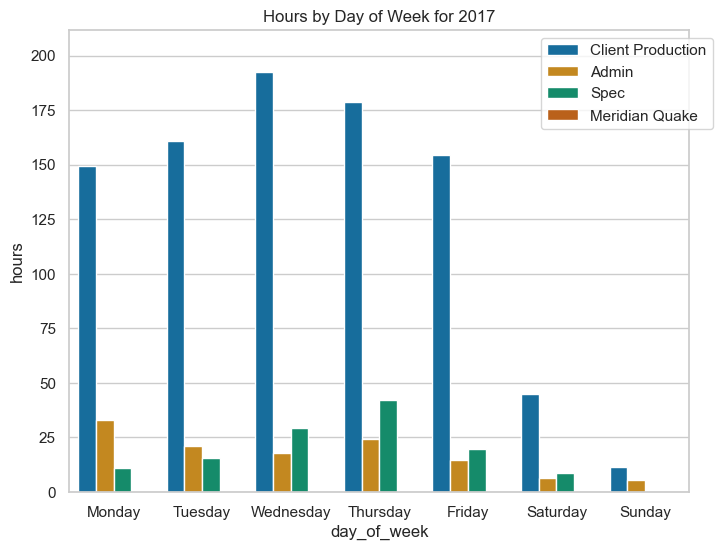

In [20]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, 'plots.gif', 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='day_of_week', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()

        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='day_of_week', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1

        # Sort by days_of_week
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plot_data['day_of_week'] = pd.Categorical(plot_data['day_of_week'], categories=days_order, ordered=True)
        plot_data = plot_data.sort_values('day_of_week')
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='day_of_week', y='hours', hue='activity', data=plot_data, ax=ax, palette='colorblind')
        ax.set_title(f'Hours by Day of Week for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        ax.set_ylim(0, max_hours)
        
        writer.grab_frame()
        plt.show()


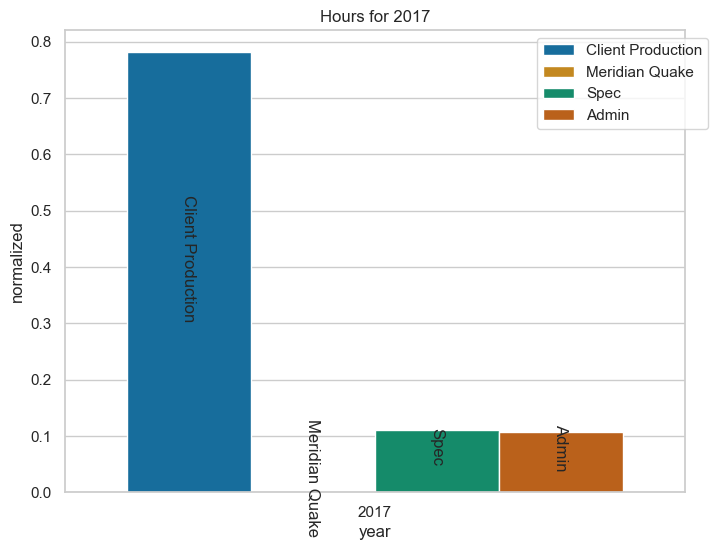

In [21]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, 'plots_year_normalized.gif', 100):
    max_hours_normalized = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='year', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()

        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='year', value_name='hours', var_name='activity')

        # Create normalized column
        plot_data['normalized'] = plot_data['hours']/plot_data['hours'].sum()
        
        # Find the max hours for y axis
        if plot_data['normalized'].max() > max_hours_normalized:
            max_hours_normalized = plot_data['normalized'].max() * 1.1
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='year', y='normalized', hue='activity', data=plot_data, ax=ax, palette = 'colorblind')
        ax.set_title(f'Hours for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        #ax.set_ylim(0, max_hours_normalized)

        # Add hue values inside the bars
        for p, label in zip(ax.patches, plot_data['activity']):
            ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=270)
        
        writer.grab_frame()
        plt.show()


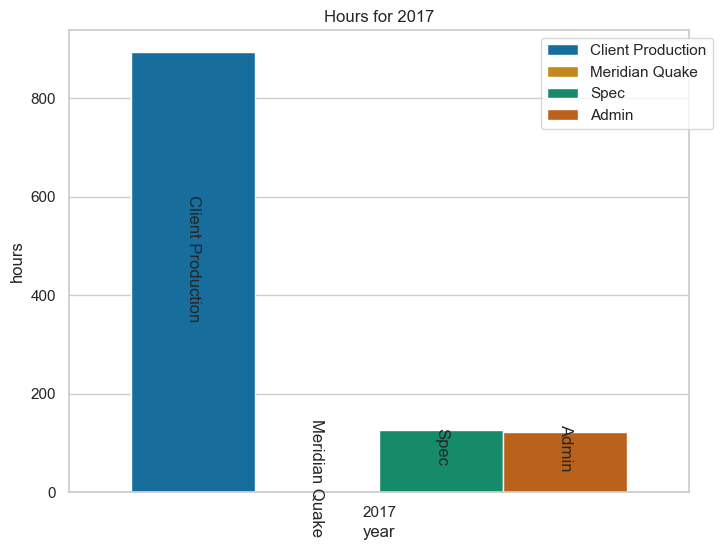

In [22]:
# Create writer and meta data
metadata = dict(title='movie', artist ='Matthew Tryba')
writer = PillowWriter(fps=0.5, metadata=metadata)

# Initialize the figure and axes outside of the loop
fig, ax = plt.subplots(figsize=(8,6))

with writer.saving(fig, 'plots_year.gif', 100):
    max_hours = 0

    for year in years_list:
        # Filter dataframe by year
        time_tracking_by_year = time_tracking[time_tracking['year'] == year]

         # Create a pivot table with day_of_week as index, activity as columns, and hours as values
        pivot_data = time_tracking_by_year.pivot_table(index='year', columns='activity', values='hours', aggfunc='sum')

        # Ensure all activities are present by reindexing
        pivot_data = pivot_data.reindex(columns=business_activities, fill_value=0).reset_index()
        
        # Melt the data to get it back to long format for plotting
        plot_data = pivot_data.melt(id_vars='year', value_name='hours', var_name='activity')
        
        # Find the max hours for y axis
        if plot_data['hours'].max() > max_hours:
            max_hours = plot_data['hours'].max() * 1.1
        
        # Clear the current axes (necessary to avoid overlapping plots)
        ax.clear()
        
        # Create barplots for each year
        sns.barplot(x='year', y='hours', hue='activity', data=plot_data, ax=ax, palette= 'colorblind')
        ax.set_title(f'Hours for {year}')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        #ax.set_ylim(0, max_hours)

        # Add hue values inside the bars
        for p, label in zip(ax.patches, plot_data['activity']):
            ax.annotate(label, (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', rotation=270)
        
        writer.grab_frame()
        plt.show()


### Analyzing Days Between Project Funding

In [23]:
# Create and filter dataframe
fund_dates = project_hours[['fund_date', 'total_after_fees', 'artist']]
fund_dates = fund_dates.sort_values(by='fund_date', ascending=True).reset_index(drop = True)
fund_dates = fund_dates[fund_dates['fund_date'] > '2018-12-31']
fund_dates['days_between'] = 0
fund_dates['deposit'] = round(fund_dates['total_after_fees']/2, 2)

# iterate through fund_date and calculate the days between each successive date
for i in range(len(fund_dates)):
    if i == 0:
        fund_dates.loc[i, 'days_between'] = 0
    else:
        fund_dates.loc[i, 'days_between'] = (fund_dates.loc[i, 'fund_date'] - fund_dates.loc[i-1, 'fund_date']).days

fund_dates.head()

,fund_date,total_after_fees,artist,days_between,deposit
1,2019-09-03,0.459627,Cody Qualls,NaN,0.23
2,2019-10-10,0.221064,Jeff,37.0,0.11
3,2019-12-09,0.208784,Ananya Kouds,60.0,0.10
4,2020-01-16,0.294752,margaux,38.0,0.15
5,2020-02-13,0.233347,Cody G,28.0,0.12


In [24]:
''' I need to figure out how to combine rows into one sum if the artist is the same name on a given fund date
to address projects that had multiple songs funded that day'''

agg_dict = {
    'total_after_fees': 'sum',
    'days_between': 'first'  # You can use 'first' to carry the first value of days_between
}

collapsed_fund_dates = fund_dates.groupby(['fund_date', 'artist'], as_index=False).agg(agg_dict)
collapsed_fund_dates['deposit'] = round(collapsed_fund_dates['total_after_fees']/2, 2)
collapsed_fund_dates.head()

,fund_date,artist,total_after_fees,days_between,deposit
0,2019-09-03,Cody Qualls,0.459627,NaN,0.23
1,2019-10-10,Jeff,0.221064,37.0,0.11
2,2019-12-09,Ananya Kouds,0.208784,60.0,0.10
3,2020-01-16,margaux,0.294752,38.0,0.15
4,2020-02-13,Cody G,0.233347,28.0,0.12


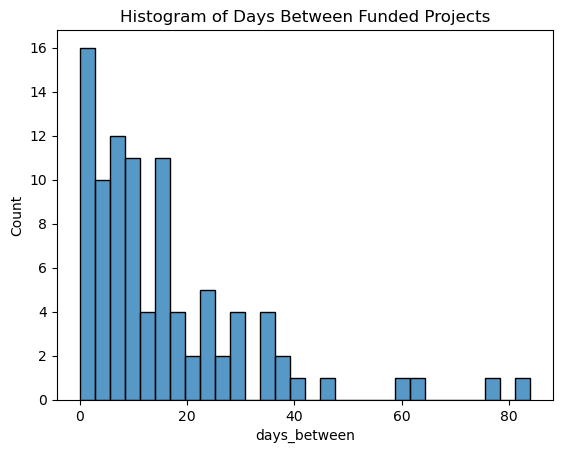

In [39]:
sns.histplot(data = collapsed_fund_dates, x = 'days_between', bins = 30)
plt.style.use('default')
plt.title('Histogram of Days Between Funded Projects')
plt.show()

In [26]:
collapsed_fund_dates.head()

,fund_date,artist,total_after_fees,days_between,deposit
0,2019-09-03,Cody Qualls,0.459627,NaN,0.23
1,2019-10-10,Jeff,0.221064,37.0,0.11
2,2019-12-09,Ananya Kouds,0.208784,60.0,0.10
3,2020-01-16,margaux,0.294752,38.0,0.15
4,2020-02-13,Cody G,0.233347,28.0,0.12


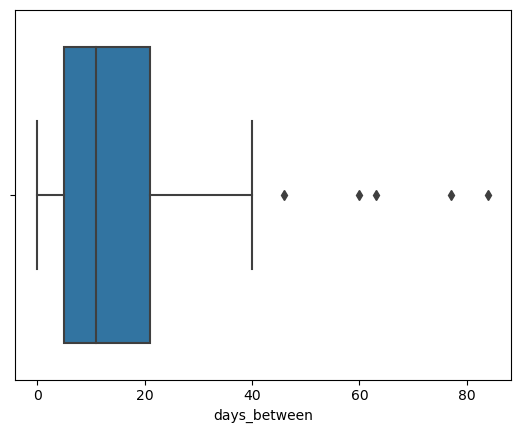

Median is 11.0 and mean is 15.494623655913978


In [27]:
sns.boxplot(data = collapsed_fund_dates, x= 'days_between')
plt.show()

median_days = collapsed_fund_dates['days_between'].median()
mean_days = collapsed_fund_dates['days_between'].mean()
print(f'Median is {median_days} and mean is {mean_days}')

#### Create bar graph with filler dates to visualize frequency of deposits

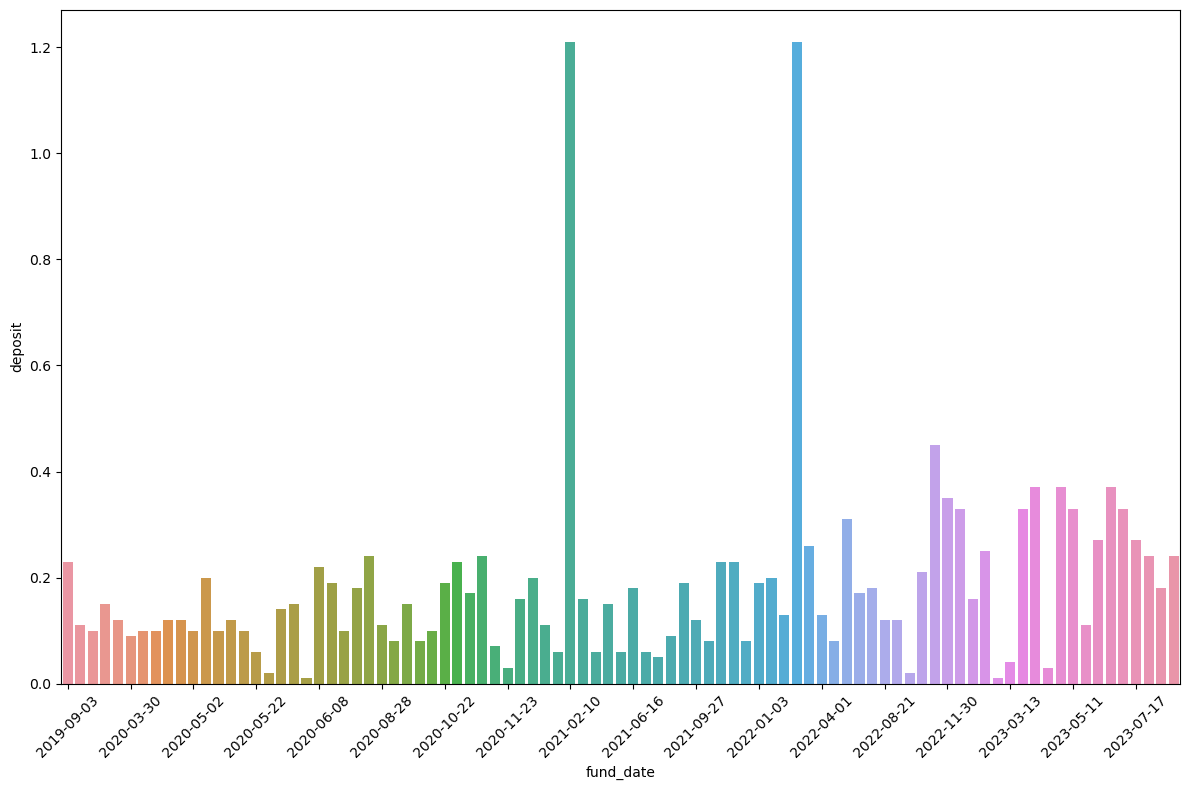

In [28]:
# Bar Graph without filler dates

funding_money_in = collapsed_fund_dates.groupby('fund_date')['deposit'].sum().reset_index()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data= funding_money_in, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(funding_money_in), 5)  # Show every nth date
x_tick_labels = funding_money_in.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()

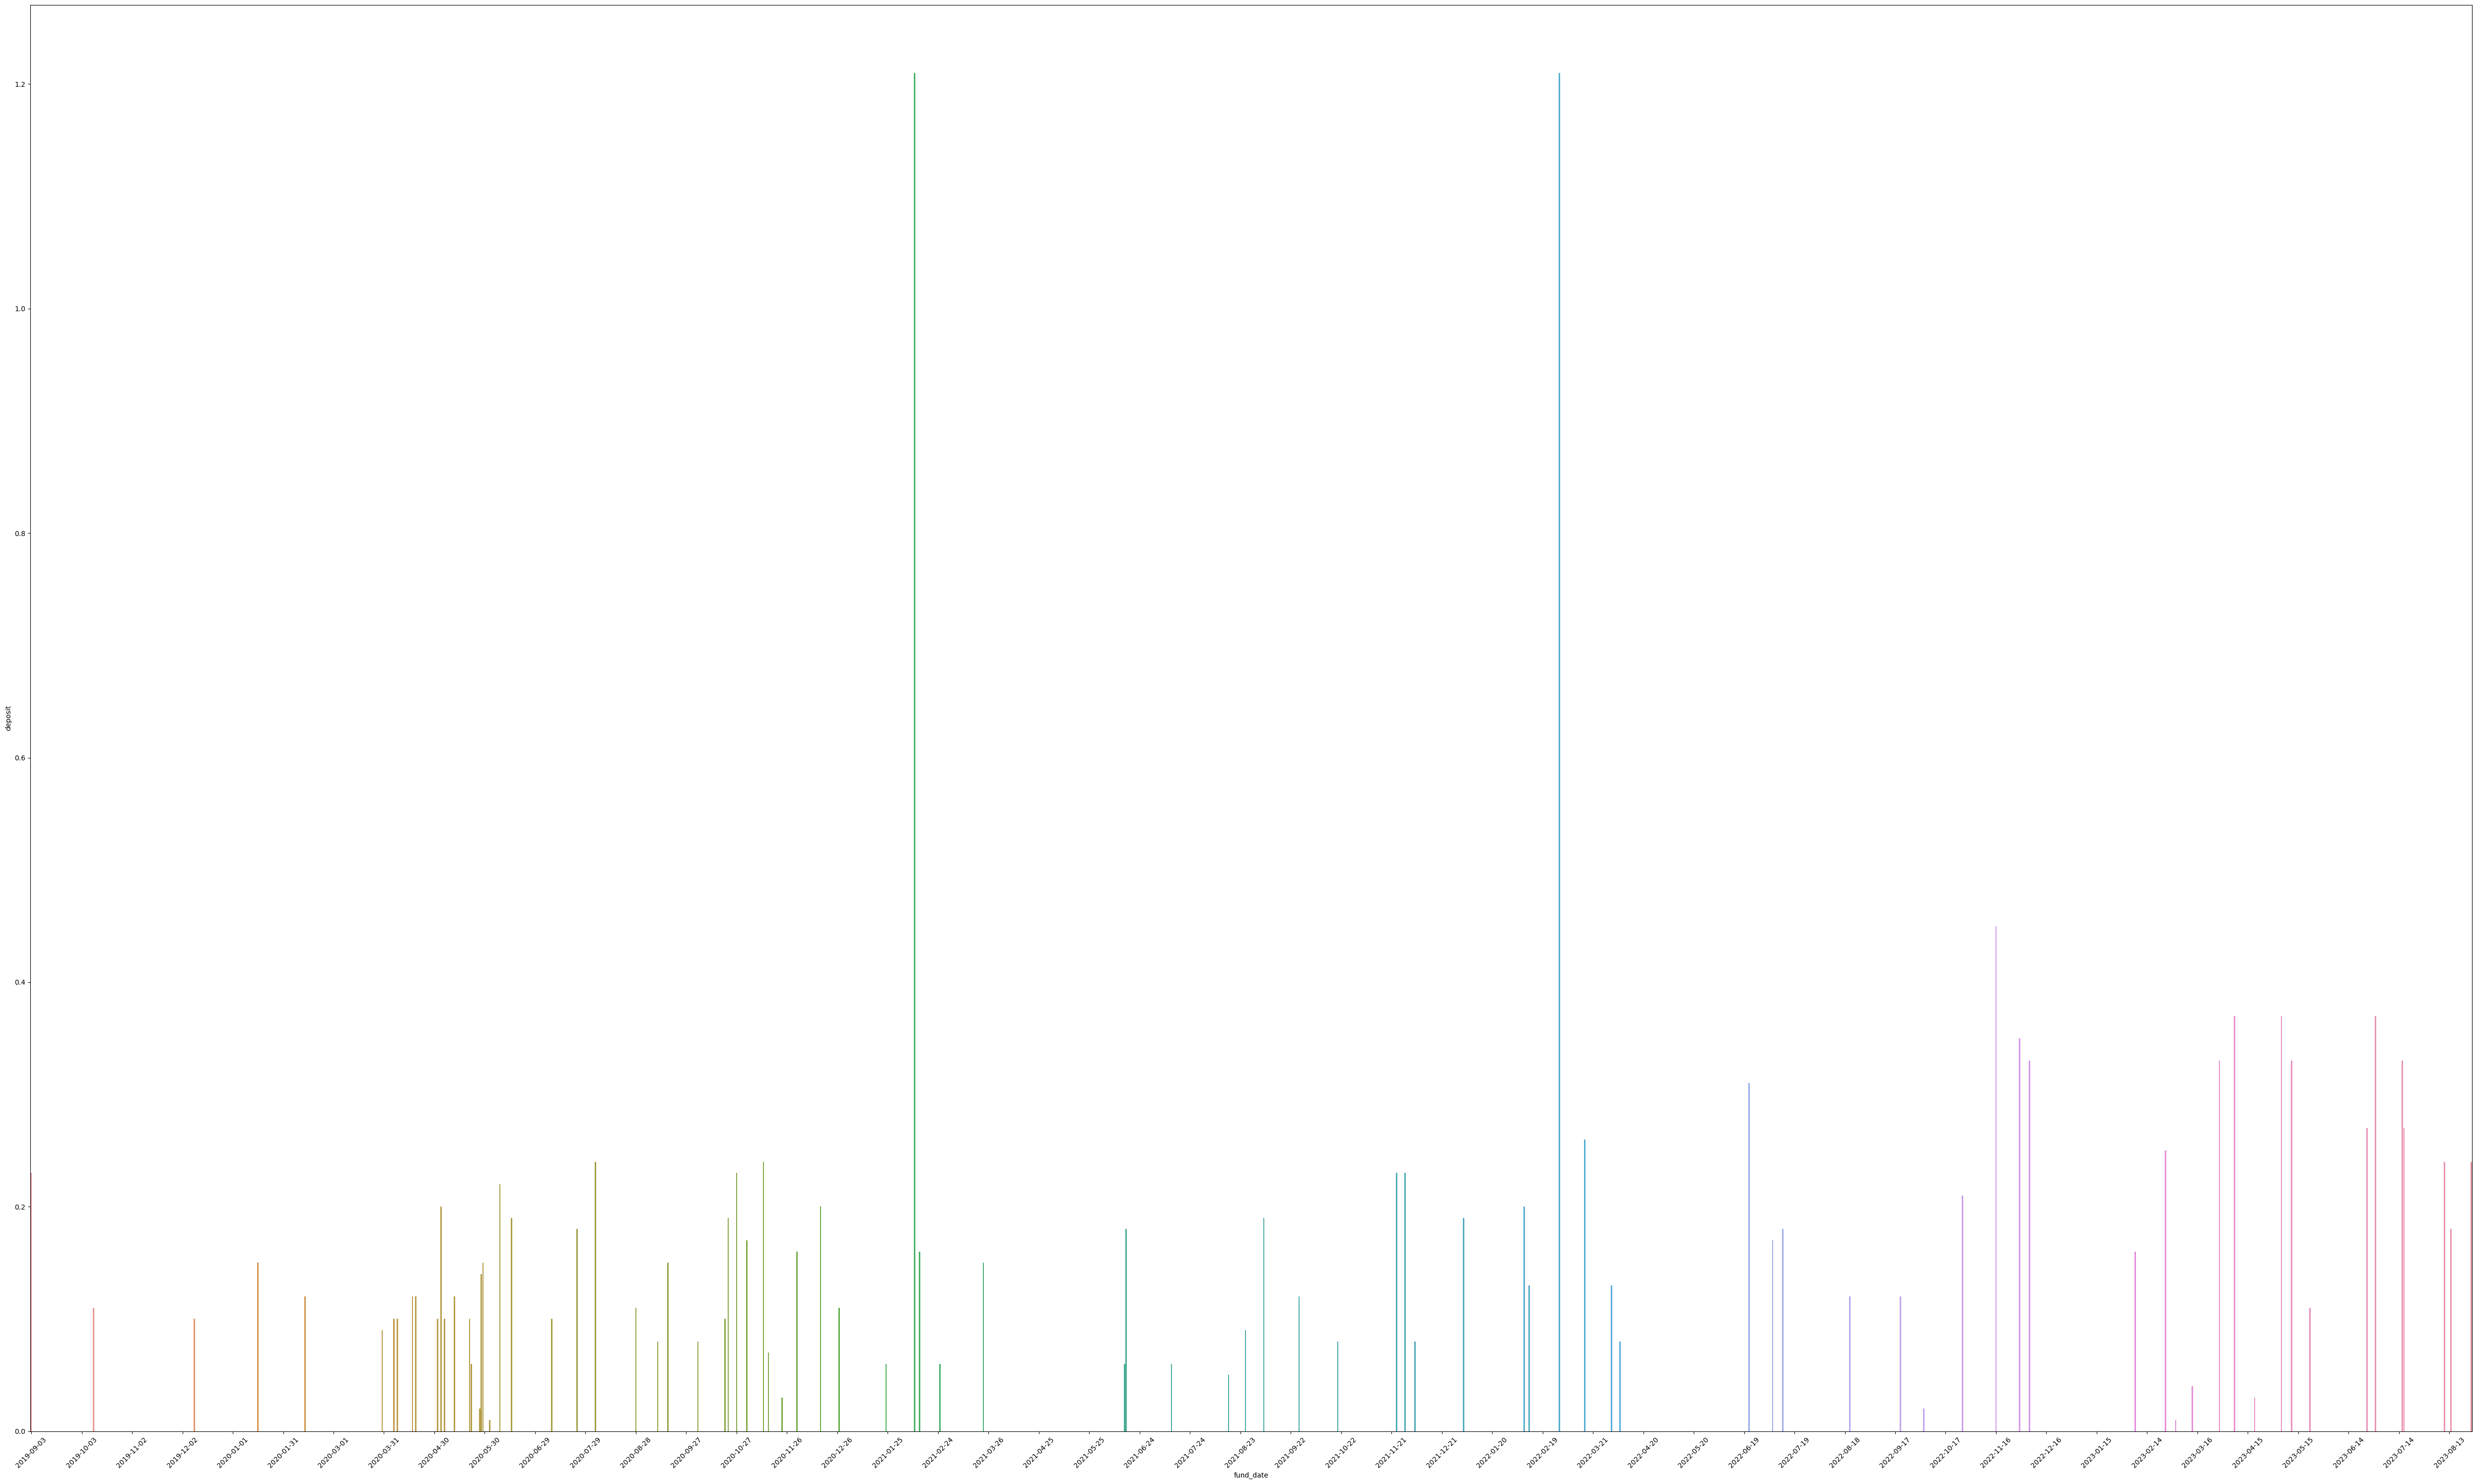

In [29]:
# The below graph gives a sense of how the deposits are spread through time

# Determine Date Range
fund_date_min = fund_dates['fund_date'].min()
fund_date_max = fund_dates['fund_date'].max()
date_range = pd.date_range(start = fund_date_min, end = fund_date_max, freq='D')

# Create dataframe of just dates within range
temp_df = pd.DataFrame({'fund_date': date_range})

# Left merge data frames on 'fund_date' and fill missing with 0
new_calendar_df = temp_df.merge(funding_money_in, on='fund_date', how='left').fillna(0)

# create figure
plt.figure(figsize=(50, 30)) # needs to be very large in order to see bars
ax = sns.barplot(data= new_calendar_df, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(new_calendar_df), 30)  # Show every nth date
x_tick_labels = new_calendar_df.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()

# Evaluating 'Business Hunches'

## How likely is a Soundbetter Client to be experienced?

Null hypothesis: there is no association between a client being from Soundbetter and their experience level.

In [30]:
# Create crosstab
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'])

chi2, pval, dof, expected = chi2_contingency(Xtab)
print(f'The p-value is {pval}')

The p-value is 6.000347675463873e-27


In [31]:
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'], normalize = True).reset_index()
Xtab

experienced_client,soundbetter,False,True
0,False,0.068376,0.645299
1,True,0.235043,0.051282


In [40]:
# sns.scatterplot(x = 'experienced_client', y = 'soundbetter', data=project_hours)
# plt.show()

## Predicting Difficult Clients

### K Nearest Neighbor Classifier

In [33]:
# pre-processing the data

#make a copy of the dataframe

# desired columns
column_list = ['price','project_type', 'soundbetter', 'songwriter', 'experienced_client', 'backend_belief']
client_difficulty_data = project_hours_tracked_paid[column_list].copy()

# get labels array
client_difficuly_labels = np.array(project_hours_tracked_paid['difficult_client'])
# convert array to binary
client_difficuly_labels = client_difficuly_labels.astype(int)

#MinMax the 'price' column
price_reshaped = np.array(client_difficulty_data['price']).reshape(-1,1)
mmscaler = MinMaxScaler()

# add column of normalized price back to dataframe
client_difficulty_data['price_normalized'] = mmscaler.fit_transform(price_reshaped)



In [34]:
# one hot encode project type
ohe = pd.get_dummies(client_difficulty_data['project_type'])
client_difficulty_data = client_difficulty_data.join(ohe)

In [35]:
# cast boolean values as integers
columns_to_cast_as_int = ['soundbetter', 'experienced_client', 'backend_belief', 'additional production',
                          'full production', 'mastering', 'mixing', 'pre production', 'production tweak',
                          'track production', 'vocal production', 'songwriter']

client_difficulty_data[columns_to_cast_as_int] = client_difficulty_data[columns_to_cast_as_int].astype(int)

# drop extra columns

client_difficulty_data = client_difficulty_data.drop(['price', 'project_type'], axis=1)

In [36]:
#k_nn_client_difficulty_data.info()

In [37]:
# Split the data
training_data, validation_data, training_labels, validation_labels = train_test_split(client_difficulty_data, client_difficuly_labels, test_size=0.2, random_state=100)

print(len(training_data), len(training_labels)) # verify the length is the same

68 68


In [38]:
scores = [] # initiate blank list

for k in range(1,20): # loop through k from 1 to 100 and append the scores to the list
    classifier = KNeighborsClassifier(n_neighbors = k) # create a classifier with k neighbors
    classifier.fit(training_data, training_labels) # train the classifier
    scores.append(classifier.score(validation_data, validation_labels)) # determine the accuracy of the trained classifier

print(scores)

max_score = max(scores) # determine the max score
max_score_index = scores.index(max_score) # find the index of max score
print(max_score, max_score_index + 1) # add 1 to index to find k value for max score

''' Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off'''

[0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444, 0.9444444444444444]
0.9444444444444444 2


" Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off"

### Logistic Regression

# Create HTML Dashboard